# Import

In [3]:
#path_essentials = '/Users/Setup3-PC/Desktop/qudi/logic/setup3_logic/script_logic_essentials.py'
path_essentials = 'jupyter/Timo/from_Simon/script_logic_essentials.py'
path_toolkit = 'jupyter/Timo/own/logic_toolkit.py'
path_curdir = 'jupyter/Timo/own/'

import os, time, sys
import numpy as np

# import essentials via run
exec(open(path_essentials).read())
exec(open(path_toolkit).read())
# usual module imports
sys.path.append(path_curdir)

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

# configure this notebook
config_matplotlib_jupyter()

memory_dict=OrderedDict()
print_welcome_msg()

[Mon Jun 17 17:58:51 2019] Hi, jupyter ready. working dir: C:\Users\Setup3-PC\Desktop\qudi


# Common parameters

In [3]:
# MW parameters
common_rabi_period = 78e-9
common_mw_freq = 1.5176e9 
common_mw_amp = 0.25/2.

# Ramsey
common_mw_ramsey_offset = 1e6#1e6

# Cnot gates
common_mw_cnot_freq = common_mw_freq + 3.03e6
common_mw_cnot_period = 566.5e-9
common_mw_cnot_amp = 0.25/14.8
common_mw_cnot_freq2 = common_mw_freq
common_mw_cnot_period2 = 582.5e-9
common_mw_cnot_amp2 = 0.25/14.4

# N15 control
common_rf_period = 114e-6
common_rf_freq = 1.07457e6#1.9574e6
common_rf_amp = 0.25/2.5

common_refocus_time = 300

# Laser options

## Optimize position

In [ ]:
optimize_position()

## Laser On

In [7]:
laser_on(pulser_on = False)
laser_on_awg()

## Laser Off

In [135]:
laser_off(pulser_on = False)

# Frequency Optimization parameters

In [ ]:
optimize_freq_dict=OrderedDict()
optimize_freq_dict['mw_optimization_method'] = 'pulsedodmr'
optimize_freq_dict['optimize_generate_new'] = False
optimize_freq_dict['save_tag'] = 'optimize_frequency'
optimize_freq_dict['optimize_fit_method'] = 'N15'
optimize_freq_dict['parameters2update'] = {'center': 'microwave_frequency'}

optimize_freq_dict['name'] = 'Pulsed_ODMR'
optimize_freq_dict['rabi_period'] = 1800e-9
optimize_freq_dict['freq_start'] = 4.127e9
optimize_freq_dict['freq_step'] = 0.2e6
optimize_freq_dict['num_of_points'] = 50
optimize_freq_dict['microwave_amplitude'] = common_mw_amp/15
optimize_freq_dict['meas_type'] = conventional_measurement
optimize_freq_dict['meas_info'] = add_conventional_information

optimize_freq_dict['measurement_time'] = 30
optimize_freq_dict['optimize_time'] = None
optimize_freq_dict['optimize_generate_new'] = True

#  Preperation 

In [5]:
def setup_podmr_params(f_start):
    qmeas=OrderedDict()
    qmeas['name'] = 'Pulsed_ODMR'
    qmeas['rabi_period'] = common_rabi_period*10
    qmeas['freq_start'] = f_start
    qmeas['freq_step'] = 0.1e6
    qmeas['num_of_points'] = 50
    qmeas['microwave_amplitude'] = common_mw_amp/20

    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'
    
    return qmeas


def setup_rabi_params():
    
    qmeas=OrderedDict()
    qmeas['name'] = 'Rabi'
    qmeas['tau_start'] = 0e-9
    qmeas['tau_step'] = 2e-9
    qmeas['num_of_points'] = 50
    qmeas['microwave_frequency'] = common_mw_freq #+ 0.5*3.03e6
    qmeas['microwave_amplitude'] = common_mw_amp

    qmeas['measurement_time'] = None
    qmeas['optimize_time'] = None
    qmeas['freq_optimize_time'] = None
    #qmeas['fit_experiment'] = None  #'cosine'
    #qmeas['analysis_interval'] = 3
    #qmeas['n_sweeps'] = 5
    
    return qmeas

def setup_ramsey_params(tau, n_tau=1):
    qmeas=OrderedDict()
    qmeas['name'] = 'Ramsey'
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['tau_start'] = tau
    qmeas['tau_step'] = 100e-9
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = False
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    if n_tau > 1:
        qmeas['fit_experiment'] = 'sine_decay'
 
    return qmeas


def run_pdomr(mes_params):
    
    up_to = (mes_params['freq_start'] + mes_params['freq_step'] * mes_params['num_of_points'])
    
    do_experiment(experiment='pulsedodmr', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=True, save_tag='PulsedOdmr_'+str(round(mes_params['freq_start']))+'_'+str(up_to),load_tag='')

def run_rabi(mes_params):
    do_experiment(experiment='rabi', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='Rabi_'+str(round(mes_params['microwave_amplitude']*1000))+'mV',load_tag='')
    

def run_ramsey(mes_params,  n_sweeps_stop=0):
    
    if n_sweeps_stop > 0:
        # else don't stop by sweeps
        mes_params['n_sweeps'] = n_sweeps_stop
    
    do_experiment(experiment='ramsey', qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_conventional_information, generate_new=True, save_tag='Ramsey',load_tag='')   
    
    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)
    
    else:
        mes = get_current_pulsed_mes()
        x = mes.signal_data[0]
        y = mes.signal_data[1]
        
        return (x,y)    


## Pulsed ODMR

In [9]:
qmeas = setup_podmr_params(f_start=1.515e9)
run_pdomr(qmeas)

## Rabi

In [143]:
qmeas = setup_rabi_params()
run_rabi(qmeas)

## Ramsey


In [221]:
tau_start = 1e-6
n_sweeps = 0#1e3
z_thres = 0.82

qmeas = setup_ramsey_params(tau_start, n_tau=75)        
x, z = run_ramsey(qmeas, n_sweeps_stop=n_sweeps)
z_binary = majority_vote(z[0], z_thres=z_thres)

logger.info("Ramsey result out of {} sweeps: {} -> {}".format(n_sweeps, z, z_binary))


# MFL

In [ ]:
"""
DEBUG
n_sweeps = 20

for idx_epoch in range(0, 10):
    tau = calc_new_tau()
    B = 0
    db = 0
    logger.info("MFL Epoch {}, B/dB {} ({}), tau {}:".format(idx_epoch, B, dB, tau))
    qmeas = setup_ramsey_params(tau)
    run_ramsey(qmeas, n_sweeps_stop=n_sweeps)
"""

## Prepare MFL

In [14]:
from mfl_sensing_simplelib import *
import qinfer as qi

n_particles = 1000
freq_min = 0
freq_max = 2*np.pi*10 #MHz
# the expected T2, when 0 this is the ideal case
inv_T2 = 0


"""
units in MFL algorithm:
w [MHz*rad]
tau [us]

in track_arrays for output:
B = w [MHz*rad]
tau [s]
"""


def majority_vote(z, z_thres=0.5):
    if z > z_thres:
        return 1
    else:
        return 0
    
def DEBUG_randomize(z):
    import random
    return random.randint(0,100)*z/100.

def reset_mfl():
    
    global track_B, track_dB, track_tau
    global prior, model, updater, from_heuristic
    
    prior = qi.UniformDistribution([freq_min, freq_max])
    model = ExpDecoKnownPrecessionModel(min_freq = freq_min, invT2 = inv_T2)

    # resetting updater&heuristic for ease of multiple calls to this cell
    updater = basic_SMCUpdater(model, n_particles, prior, resample_a=0.98, resample_thresh=0.5)
    updater.reset()
    from_heuristic = stdPGH(updater, inv_field='w_')

    track_B = []  # MHz*rad
    track_dB = [] 
    track_tau = []  # us

def plot_prior(label=None):
    global prior, model, updater, from_heuristic
    # sample from distributeion and do histogram
    plt.hist(updater.sample(n=updater.n_particles)/(2*np.pi), label=label)
    plt.xlabel("B (MHz)")
    plt.legend()
    plt.show()


def run_mfl(n_epchos=5, n_sweeps=5e3, z_thres=0.85):
    global prior, model, updater, from_heuristic
    
    for idx_epoch in range(0, n_epchos):
        
        # set tau from prior
        tau_and_x = from_heuristic()
        tau = tau_and_x['t']    # us
        
        # save result of last epoch
        B = updater.est_mean()
        B_mhz = B/(2*np.pi)
        dB =  np.sqrt( updater.est_covariance_mtx() )[0]
        dB_mhz = dB / (2*np.pi)
        track_B.append(B)
        track_dB.append(dB)  
        track_tau.append(tau*1e-6)  #  to SI
        
        # plot prior
        if idx_epoch == 0 or idx_epoch == n_epchos - 1:
            plot_prior(label='Prior epoch {}'.format(idx_epoch))
                
        logger.info("MFL Epoch {}/{}, B {}+-{} MHz, tau {} ns:".format(idx_epoch, n_epchos, B_mhz[0], dB_mhz[0], 1e3*tau[0]))
        qmeas = setup_ramsey_params(tau * 1e-6, n_tau=1)
        
        _, z = run_ramsey(qmeas, n_sweeps_stop=n_sweeps)
        # z = DEBUG_randomize(z[0])    # we run only a single tau, so should be only 1 element
        z_binary = majority_vote(z[0], z_thres=z_thres)
        logger.info("Ramsey result out of {} sweeps: {} -> {}".format(n_sweeps, z, z_binary))
        
        # update prior
        updater.update(z_binary, tau_and_x)
   
    
    logger.info("MFL finishehd")

## Run MFL 

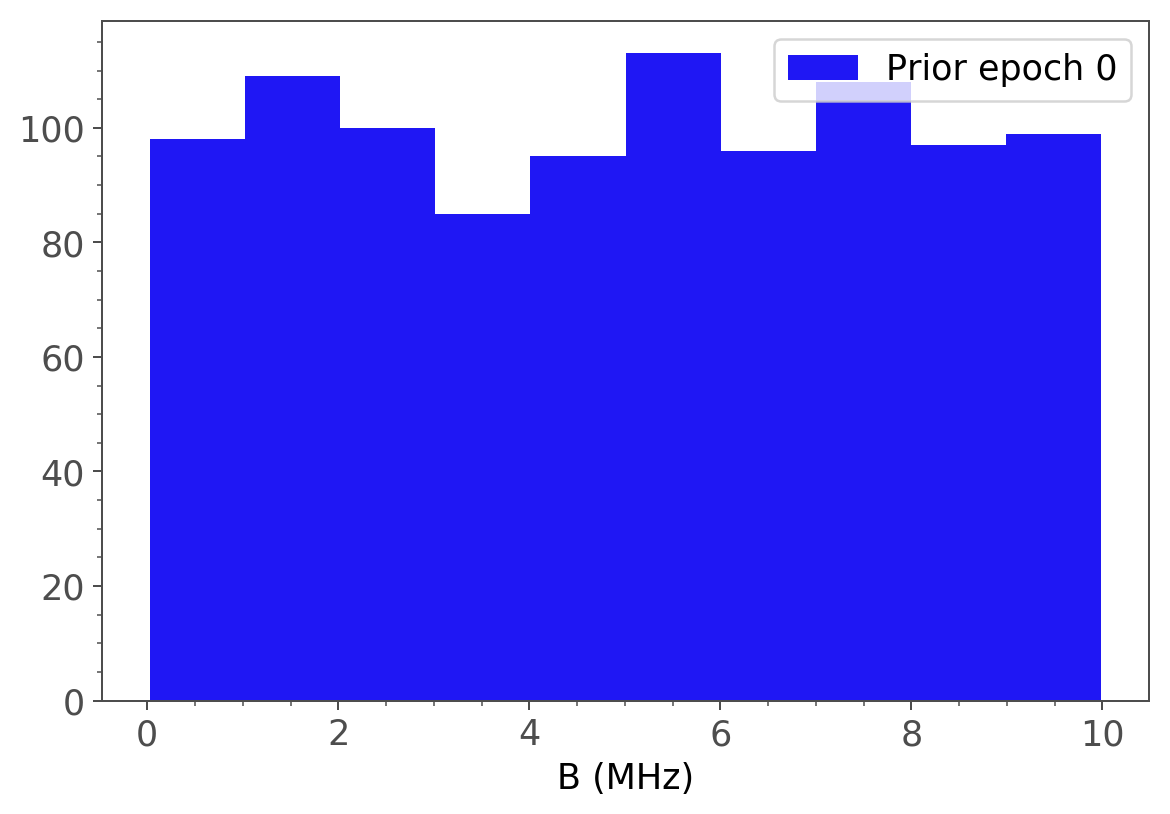

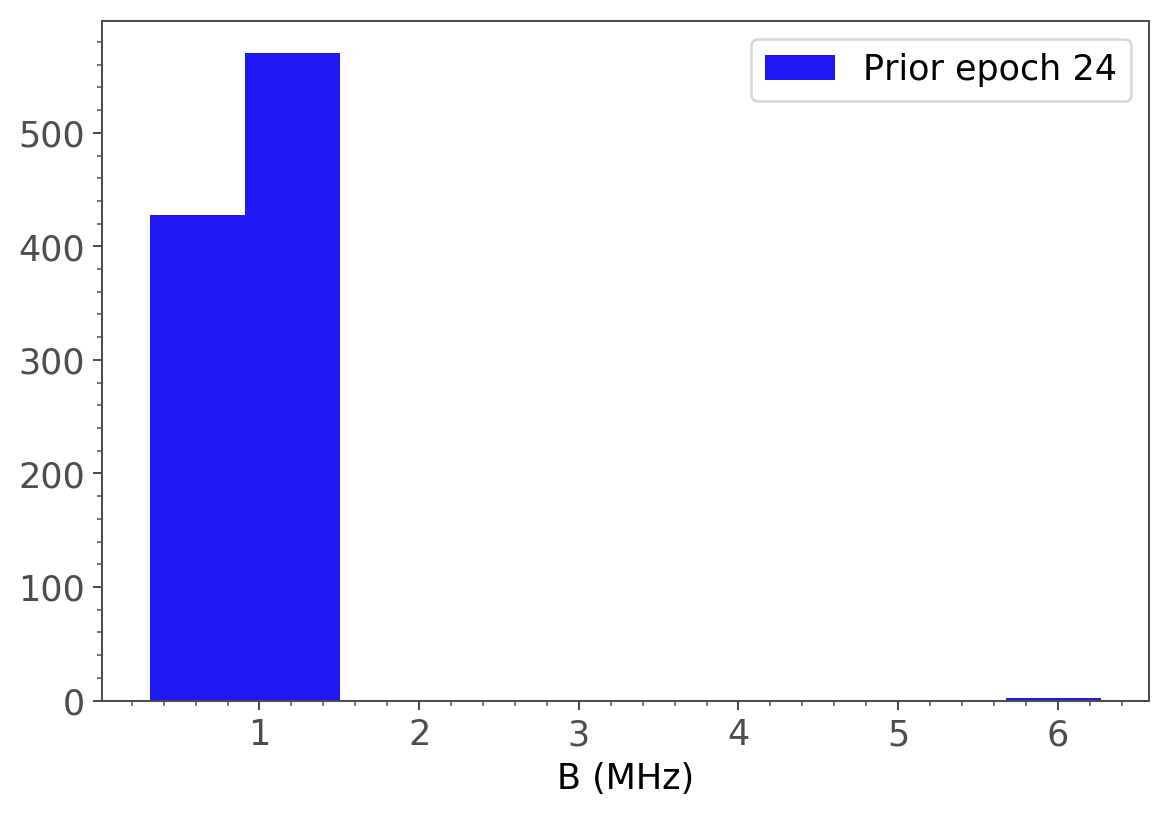

In [15]:
track_B = []
track_dB = []
track_tau = []
z_thresh = 0.833

userglobals.abort.clear()
logger.info("Starting MFL, threshold from Ramsey z={}".format(z_thresh))
reset_mfl()
run_mfl(n_epchos=25, n_sweeps=100, z_thres=0.82)

laser_on_awg()

## Plot and safe

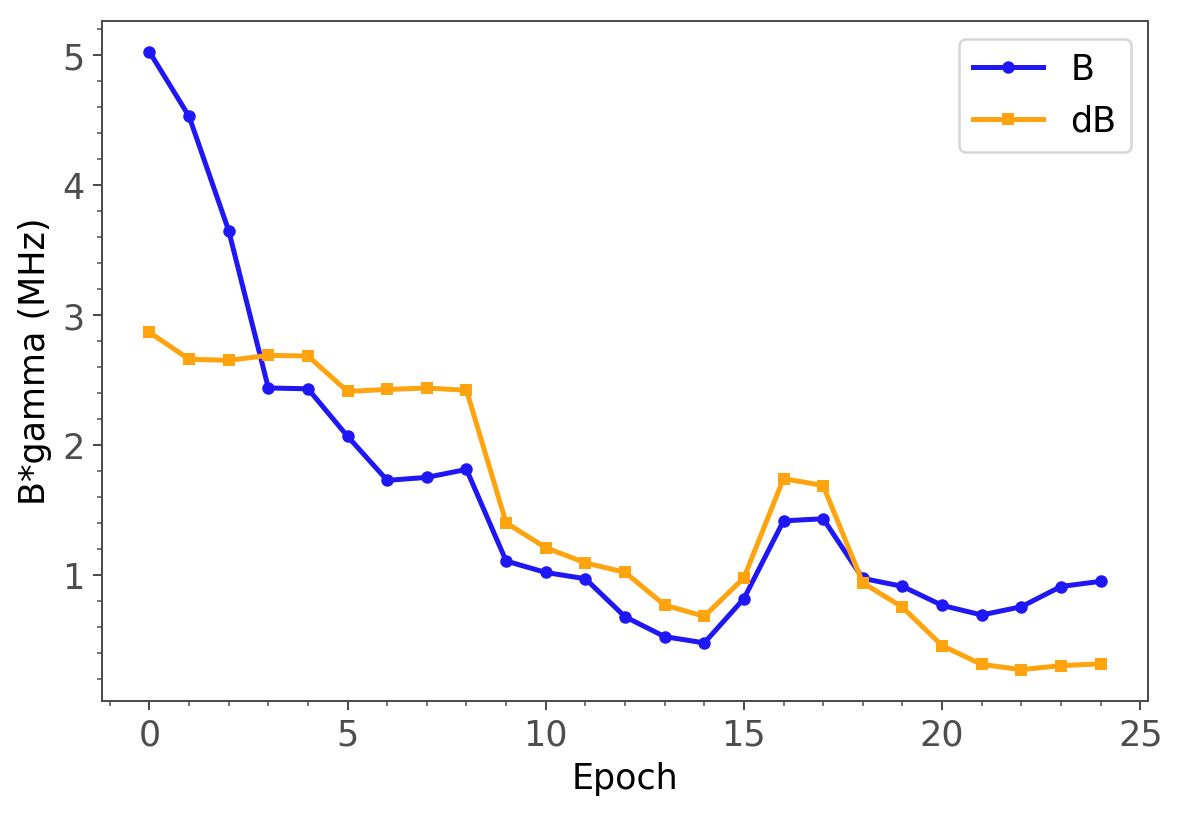

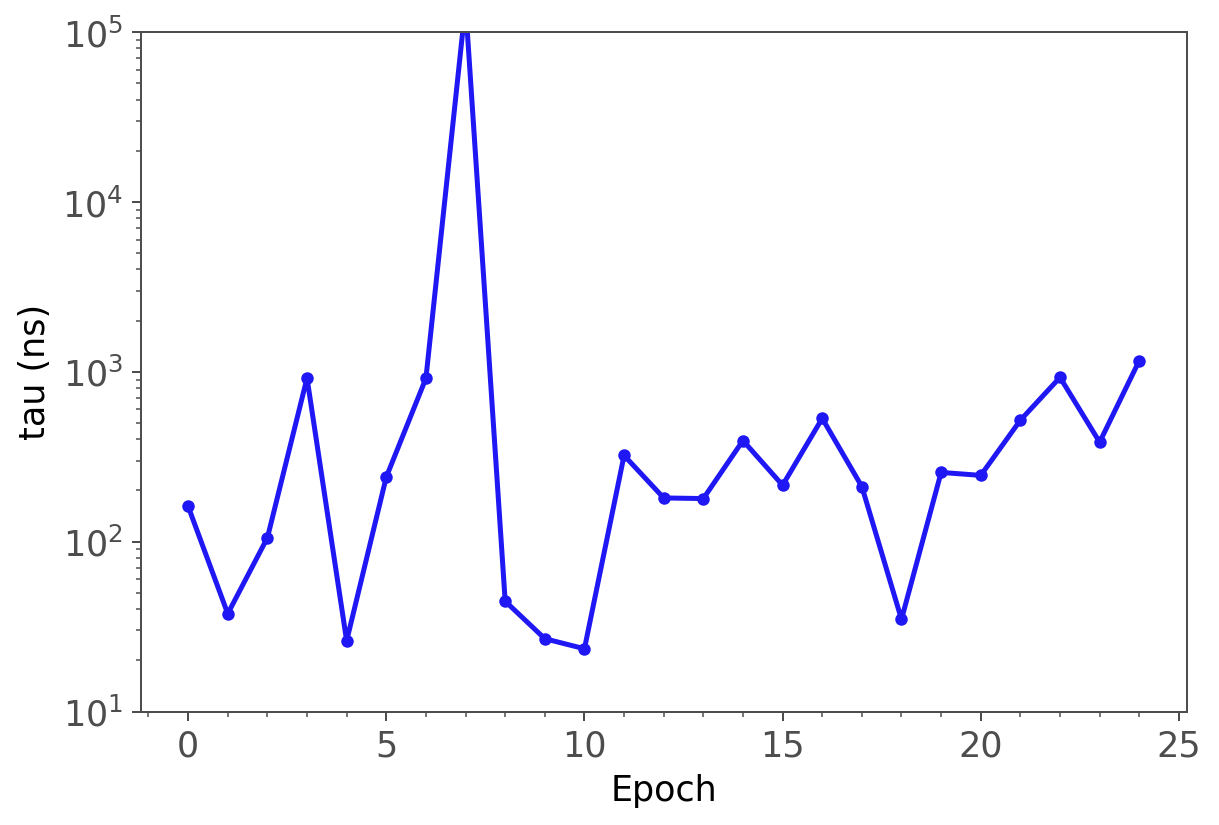

In [16]:
save_tag_0 = 'MFL'

import matplotlib.pyplot as plt
def plot_mfl_result():
    plt.plot(B_mhz, label='B')
    plt.plot(dB_mhz, label='dB')
    plt.xlabel('Epoch')
    plt.ylabel('B*gamma (MHz)')
    plt.legend()
    plt.show()
    #print(track_B)

    plt.semilogy(np.asarray(track_tau)*1e9)
    axes = plt.gca()
    axes.set_ylim([10,100000])
    plt.ylabel('tau (ns)')
    plt.xlabel('Epoch')
    plt.show()
    #print(track_tau)

# prepare results
B_mhz = (np.asarray(track_B) /(2*np.pi))[:,0]
dB_mhz =  (np.asarray(track_dB) /(2*np.pi))[:,0]
tau_ns = (np.asarray(track_tau)*1e9)[:,0]
x = np.asarray(range(0, len(track_B)))

plot_mfl_result()

# save as pulsed mes
save_tag = save_tag_0 + '_tau'
inject_data_to_current_mes(x, tau_ns, dy=dB_mhz, labels_xy=['Epoch','tau'], units_xy=['','ns'])
pulsedmasterlogic.save_measurement_data(save_tag, False)

save_tag = save_tag_0 + '_b'
inject_data_to_current_mes(x, B_mhz, dy=dB_mhz, labels_xy=['Epoch','B*gamma'], units_xy=['','MHz'])
pulsedmasterlogic.save_measurement_data(save_tag, True)







# Fit from script


In [ ]:
import copy

pulsedmeasurementlogic.fc.set_current_fit('t2')

data = pulsedmeasurementlogic.signal_data

params={'order': {'value':16, 'vary': False}}
params['amp'] = {'value':40e3, 'min':10e3, 'max':75e3, 'vary': True}
#freq = np.round(1/2/187.2e-9)
#params['frequency'] = {'value':freq, 'min':2.66e6, 'max':2.666e6, 'vary': True}
#params['frequency'] = {'value':freq, 'vary': False}
params['phase'] = {'value':np.pi, 'vary': False}
#params['offset'] = {'value':0.87, 'vary': False}


x_fit, y_fit, result = pulsedmeasurementlogic.fc.do_fit(data[0], data[1], params)

fit_data = np.array([x_fit, y_fit])

pulsedmeasurementlogic.signal_fit_data = fit_data
pulsedmeasurementlogic.fit_result = copy.deepcopy(pulsedmeasurementlogic.fc.current_fit_result)
pulsedmeasurementlogic.sigFitUpdated.emit(pulsedmeasurementlogic.fc.current_fit, 
                                          pulsedmeasurementlogic.signal_fit_data, 
                                          pulsedmeasurementlogic.fit_result,
                                          False)

result.result_str_dict

# Further Measurements

## Rabi alternating

In [ ]:
qmeas=OrderedDict()
qmeas['name'] = 'Rabi'
qmeas['tau_start'] = 0e-9
qmeas['tau_step'] = 20e-9
qmeas['num_of_points'] = 50
qmeas['microwave_frequency'] = common_mw_freq #+ 3.03e6
qmeas['microwave_amplitude'] = 0.25/14.4

qmeas['measurement_time'] = None

qmeas['optimize_time'] = None
qmeas['freq_optimize_time'] = None
qmeas['fit_experiment'] = None #'cosine'

do_experiment(experiment='rabi_alternating', qm_dict=qmeas, meas_type=conventional_measurement, meas_info=add_conventional_information,
              generate_new=True, save_tag='Rabi_'+str(round(qmeas['microwave_amplitude']*1000))+'mV',load_tag='')

In [ ]:
test = [0,2,3,4]
test1 = [5,7,8,9]

test2 = [0,3,6]

[x for x in test2 if x-1 in np.concatenate((test,test1))]

In [ ]:
bright_charge = singleshotlogic.bright_states
dark_charge = singleshotlogic.dark_states

bright_filtered = [x for x in bright_charge if x-1 in np.concatenate((bright_charge,dark_charge))]
dark_filtered = [x for x in dark_charge if x-1 in np.concatenate((bright_charge,dark_charge))]

bright = [x for x in bright_filtered if x%2!=0]
dark = [x for x in dark_filtered if x%2!=0]

bright_alt = [x for x in bright_filtered if x%2==0]
dark_alt = [x for x in dark_filtered if x%2==0]

mapped_state = len(bright)/(len(bright)+len(dark))
mapped_alt = len(bright_alt)/(len(bright_alt)+len(dark_alt))

#sorted(np.concatenate((bright_charge,dark_charge)))
#singleshotlogic.charge_state[:10]
print(mapped_alt)
print(mapped_state)

In [ ]:
np.where(singleshotlogic.charge_state < singleshotlogic.charge_threshold)[0]